In [1]:
# 00_determinism_setup — run FIRST in a fresh kernel (BEFORE importing tensorflow)
import os, sys, random
import numpy as np

SEED = 42

# --- Env vars that must be set BEFORE importing TF ---
os.environ["TF_DETERMINISTIC_OPS"]   = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"]  = "0"   # avoid oneDNN nondeterminism on CPU
os.environ["OMP_NUM_THREADS"]        = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"

# Note: PYTHONHASHSEED vendoset në nisje të procesit; në notebook s'e ndryshojmë dot tani.
# Kjo rrallë ndikon, për sa kohë s'varen rezultatet nga rendi i seteve/dikteve.

# --- Seeds for Python, NumPy ---
random.seed(SEED)
np.random.seed(SEED)

# --- Import TF vetëm pasi u vendosën env vars ---
import tensorflow as tf

# Seed për TF/Keras (mbulon initializers, shuffling, dropout, etj.)
try:
    tf.keras.utils.set_random_seed(SEED)   # TF ≥ 2.9
except Exception:
    tf.random.set_seed(SEED)

# Ops deterministike (ku mbështeten)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

# Kontrollo fijet brenda TF
try:
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)
except Exception:
    pass

# (Opsionale) fiksim pajisjeje
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # vetëm GPU 0
# os.environ["CUDA_VISIBLE_DEVICES"] = ""    # vetëm CPU

# Sigurohu që TF s'ka qenë importuar më herët
if "tensorflow" in sys.modules and sys.modules["tensorflow"] is not tf:
    raise RuntimeError("TensorFlow ishte importuar më parë. Bëj Kernel → Restart pastaj ekzekuto këtë qelizë e para.")

# Info të dobishme për log
print("Determinism setup done.")
print("TF:", tf.__version__, "| NumPy:", np.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


Determinism setup done.
TF: 2.16.1 | NumPy: 1.26.4
GPUs: []


Epoch 1/80


C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - loss: 0.4086 - val_loss: 0.1347 - learning_rate: 5.0000e-04
Epoch 2/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - loss: 0.1171 - val_loss: 0.1342 - learning_rate: 5.0000e-04
Epoch 3/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - loss: 0.0937 - val_loss: 0.1228 - learning_rate: 5.0000e-04
Epoch 4/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - loss: 0.0804 - val_loss: 0.1111 - learning_rate: 5.0000e-04
Epoch 5/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - loss: 0.0704 - val_loss: 0.1032 - learning_rate: 5.0000e-04
Epoch 6/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - loss: 0.0623 - val_loss: 0.0942 - learning_rate: 5.0000e-04
Epoch 7/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - loss: 0.0561 - val_loss: 0.0921 - learning_rate: 5.0000e-04
Epoch 8/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - loss: 0.0509 - val_loss: 0.0872 - learning_rate: 5.0000e-04
Epoch 9/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - loss: 0.0466 - val

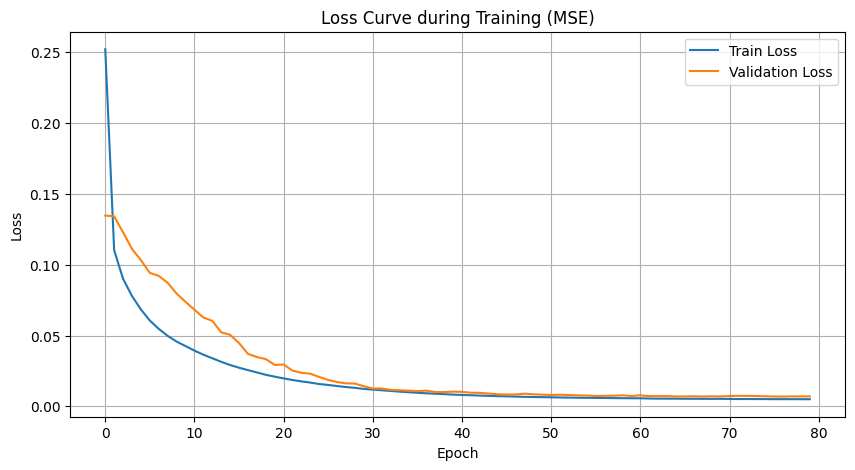


--- Metrics on TEST ---
[Bidirectional GRU (+ Holidays)] MAE: 77.91 | RMSE: 100.63 | MAPE: 15.50% | R²: 0.7621 | Accuracy: 84.50%


C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


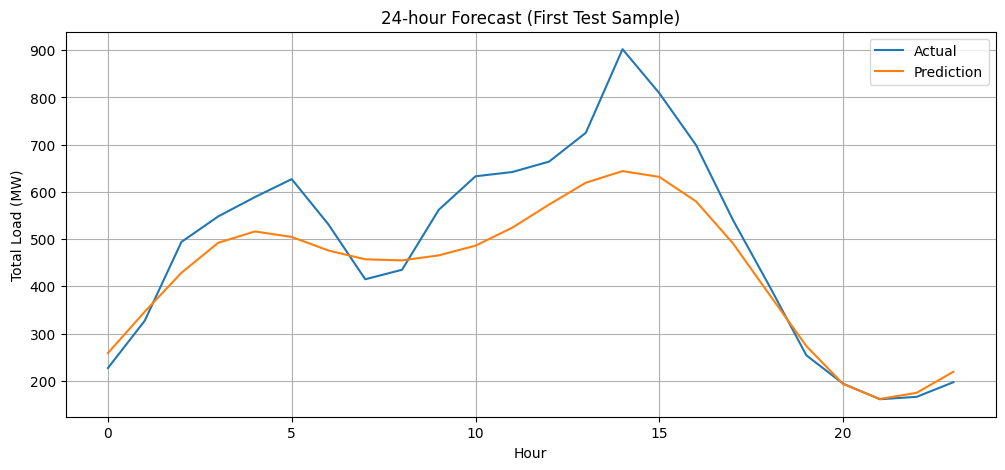

In [2]:
# =============================================
# Bidirectional GRU 24→24 with strong features
# + Country holidays (AL, ME, XK, GR) & weekend
# - Train/Val/Test split by time (70/10/20)
# - Scaler fitted only on TRAIN
# - Extra lags + Fourier seasonality
# - EarlyStopping + ReduceLROnPlateau
# =============================================

import re
import sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
)

# install/import 'holidays' for country calendars
try:
    import holidays
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "holidays"])
    import holidays

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# -----------------------------
# 0) Reproducibility
# -----------------------------
np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------
# 1) Load & clean data
# -----------------------------
df = pd.read_csv("ost_data_clean.csv", sep=';', engine='python')

# Parse date/time
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
df['Ora']  = df['Ora'].astype(str).apply(lambda x: re.findall(r'\d+', x)[0]).astype(int).astype(str).str.zfill(2)
df['Datetime'] = pd.to_datetime(df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'],
                                format='%Y-%m-%d %H', errors='coerce')
df.set_index('Datetime', inplace=True)
df.dropna(inplace=True)

# Build total cross-border exchange if missing
if 'Shkembimi fizik nderkufitar' not in df.columns:
    for c in ['Shkembimi fizik nderkufitar AL-ME',
              'Shkembimi fizik nderkufitar AL-KS',
              'Shkembimi fizik nderkufitar AL-GR']:
        if c not in df.columns:
            df[c] = 0.0
    df['Shkembimi fizik nderkufitar'] = (
        df['Shkembimi fizik nderkufitar AL-ME'] +
        df['Shkembimi fizik nderkufitar AL-KS'] +
        df['Shkembimi fizik nderkufitar AL-GR']
    )

# Select base features
cols = [
    'Ngarkesa Totale',
    'Prodhimi Total',
    'Shkembimi fizik nderkufitar',
    'Shkembimi fizik nderkufitar AL-ME',
    'Shkembimi fizik nderkufitar AL-KS',
    'Shkembimi fizik nderkufitar AL-GR'
]
df = df[cols].copy()

# -----------------------------
# 1.1) Add calendar features (hour, weekday, weekend, holidays)
# -----------------------------
df['Hour']      = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Weekend']   = (df.index.dayofweek >= 5).astype(int)

def add_country_holidays(frame: pd.DataFrame) -> pd.DataFrame:
    """Add binary holiday flags for AL, ME, XK, GR and combined ANY."""
    years = sorted(frame.index.year.unique())
    idx_dates = pd.Series(frame.index.date, index=frame.index)  # datetime.date

    def flag_for(code, fallback=None):
        try:
            h = holidays.CountryHoliday(code, years=years)
        except Exception:
            # Kosovo sometimes needs explicit class name fallback
            if fallback is not None:
                h = fallback(years=years)
            else:
                h = {}
        return idx_dates.isin(h).astype(int)

    frame['Holiday_AL'] = flag_for('AL')
    frame['Holiday_ME'] = flag_for('ME')
    # Kosovo: try 'XK', fallback to holidays.Kosovo if available
    try:
        frame['Holiday_XK'] = flag_for('XK')
    except Exception:
        # not all versions expose CountryHoliday('XK'); try class
        try:
            frame['Holiday_XK'] = idx_dates.isin(holidays.Kosovo(years=years)).astype(int)
        except Exception:
            frame['Holiday_XK'] = 0
    frame['Holiday_GR'] = flag_for('GR')

    hol_cols = ['Holiday_AL', 'Holiday_ME', 'Holiday_XK', 'Holiday_GR']
    frame['Holiday_ANY'] = frame[hol_cols].max(axis=1).astype(int)
    return frame

df = add_country_holidays(df)

# -----------------------------
# 1.2) Target lags & Fourier seasonality
# -----------------------------
df['lag_1']   = df['Ngarkesa Totale'].shift(1)
df['lag_24']  = df['Ngarkesa Totale'].shift(24)
df['lag_48']  = df['Ngarkesa Totale'].shift(48)
df['lag_168'] = df['Ngarkesa Totale'].shift(168)  # weekly memory

def add_fourier(df_in, tag, period, K=3):
    t = np.arange(len(df_in), dtype=float)
    for k in range(1, K+1):
        df_in[f'{tag}_sin_{period}_{k}'] = np.sin(2*np.pi*k*t/period)
        df_in[f'{tag}_cos_{period}_{k}'] = np.cos(2*np.pi*k*t/period)
    return df_in

df = add_fourier(df, 'fourier_daily', 24,  K=3)
df = add_fourier(df, 'fourier_weekly', 168, K=3)

# Drop NaNs created by lags
df.dropna(inplace=True)

# -----------------------------
# 2) Create sequences 24→24
# -----------------------------
target_col = 'Ngarkesa Totale'
target_idx = df.columns.get_loc(target_col)
n_input  = 24
n_output = 24

def make_sequences(df_frame, n_in=24, n_out=24):
    X, y, future_hours = [], [], []
    idx = df_frame.index
    for i in range(n_in, len(df_frame) - n_out + 1):
        past_block   = df_frame.iloc[i - n_in:i].values
        future_block = df_frame.iloc[i:i + n_out, target_idx].values
        hours        = idx[i:i + n_out].hour.values
        X.append(past_block)
        y.append(future_block)
        future_hours.append(hours)
    return np.array(X), np.array(y), np.array(future_hours)

# Time-based split (70/10/20)
n_total     = len(df)
i_train_end = int(n_total * 0.70)
i_val_end   = int(n_total * 0.80)

df_train = df.iloc[:i_train_end].copy()
df_val   = df.iloc[i_train_end:i_val_end].copy()
df_test  = df.iloc[i_val_end:].copy()

# -----------------------------
# 3) Scaling (fit only on TRAIN)
# -----------------------------
scaler = MinMaxScaler()
scaler.fit(df_train)

df_train_s = pd.DataFrame(scaler.transform(df_train), columns=df.columns, index=df_train.index)
df_val_s   = pd.DataFrame(scaler.transform(df_val),   columns=df.columns, index=df_val.index)
df_test_s  = pd.DataFrame(scaler.transform(df_test),  columns=df.columns, index=df_test.index)

X_train, y_train, hours_train = make_sequences(df_train_s, n_input, n_output)
X_val,   y_val,   hours_val   = make_sequences(df_val_s,   n_input, n_output)
X_test,  y_test,  hours_test  = make_sequences(df_test_s,  n_input, n_output)

input_shape = (X_train.shape[1], X_train.shape[2])

# Helper to inverse only the target column
t_min = scaler.data_min_[target_idx]
t_max = scaler.data_max_[target_idx]
def inv_target(y_scaled):
    return y_scaled * (t_max - t_min) + t_min

# -----------------------------
# 4) Build & train model
# -----------------------------
def build_model():
    units1, units2 = 128, 64
    dr, l2r = 0.35, 1e-4
    model = Sequential([
        Bidirectional(GRU(units=units1, return_sequences=True,
                          kernel_regularizer=l2(l2r),
                          recurrent_regularizer=l2(l2r),
                          bias_regularizer=l2(l2r)),
                      input_shape=input_shape),
        Dropout(dr),
        LayerNormalization(),
        Bidirectional(GRU(units=units2, return_sequences=False,
                          kernel_regularizer=l2(l2r),
                          recurrent_regularizer=l2(l2r),
                          bias_regularizer=l2(l2r))),
        Dropout(dr),
        Dense(24, kernel_regularizer=l2(l2r))
    ])
    opt = Adam(learning_rate=5e-4, clipnorm=1.0)
    model.compile(optimizer=opt, loss='mse')
    return model

model  = build_model()
early  = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5,
                            min_lr=1e-5, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early, plateau],
    verbose=1
)

# -----------------------------
# 5) Loss curve 
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve during Training (MSE)')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.grid(True); plt.legend()
plt.savefig("loss_curve_bidirectional_GRU.png", dpi=600, bbox_inches='tight')
plt.show()

# -----------------------------
# 6) Predict & inverse-transform
# -----------------------------
y_pred_test = model.predict(X_test, verbose=0)
y_test_res  = inv_target(y_test)
y_pred_res  = inv_target(y_pred_test)

# -----------------------------
# 7) Metrics (TEST)
# -----------------------------
def evaluate(y_true_2d, y_pred_2d, tag):
    yt = y_true_2d.reshape(-1)
    yp = y_pred_2d.reshape(-1)
    mae  = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp, squared=False)
    eps  = 1e-6
    yt_safe = np.where(yt == 0, eps, yt)
    mape = mean_absolute_percentage_error(yt_safe, yp) * 100
    r2   = r2_score(yt, yp)
    acc  = 100 - mape
    print(f"[{tag}] MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}% | R²: {r2:.4f} | Accuracy: {acc:.2f}%")
    return mae, rmse, mape, r2, acc

print("\n--- Metrics on TEST ---")
evaluate(y_test_res, y_pred_res, "Bidirectional GRU (+ Holidays)")

# -----------------------------
# 8) 24-hour forecast plot (first test sample) 
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(y_test_res[0], label='Actual')
plt.plot(y_pred_res[0], label='Prediction')
plt.title('24-hour Forecast (First Test Sample)')
plt.xlabel('Hour'); plt.ylabel('Total Load (MW)')
plt.grid(True); plt.legend()
plt.savefig("forecast_first_sample_bidirectional_GRU.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
import subprocess, sys
with open("requirements_lock.txt","w") as f:
    f.write(subprocess.check_output([sys.executable,"-m","pip","freeze"]).decode())
